# Data Preprocessing: PPG Data

This notebook will preprocess the PPG data in the the WEEE dataset using the `HeartPy` library.

## Imports and Data Loading

In [1]:
# imports
import os
from envyaml import EnvYAML

import heartpy as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import tsfresh.feature_extraction.feature_calculators as fc

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# environment configuration
VAR_ENV = EnvYAML("../../../env.yaml")
DATASET_PATH = os.path.join("../../..", VAR_ENV["dataset.path"])
DATASET_VERSION = VAR_ENV["dataset.version"]
DATASET_OUTPUT_VERSION = VAR_ENV["dataset.output"]
PARTICIPANTS = VAR_ENV["dataset.participants"]

In [3]:
path_list = [os.path.join(DATASET_PATH, DATASET_VERSION, f"P{i:02d}") for i in range(1, PARTICIPANTS + 1)]

### Loading E4 PPG Data

PPG data of E4 device is stored in the `BVP.csv` files.

In [4]:
# loading data
ppg_e4_dfs = [pd.read_csv(os.path.join(path, "E4", "BVP.csv")) for path in path_list]

Now let's separate the frequency from the data. Also, we will reshape the dataset such that the minimum value is now 0.

In [5]:
STARTING_TIMES = [df.columns[0] for df in ppg_e4_dfs] # unix starting times
FREQUENCY = 64.0 # 64 Hz
ppg_e4_dfs = list(map(lambda df: pd.DataFrame(data=df.iloc[1:].values, columns=["ppg_raw"]), ppg_e4_dfs))

Now let's add the Timestamp to the data.

In [6]:
# add timestamp
def add_timestamp(df, starting_time):
    df["timestamp"] = float(starting_time) + df.index/FREQUENCY
    new_cols = ["timestamp"] + df.columns.tolist()[:-1]
    df = df[new_cols]
    return df

In [7]:
ppg_e4_dfs = [add_timestamp(df, STARTING_TIMES[i]) for i, df in enumerate(ppg_e4_dfs)]

### Remove data out of range

In [8]:
# load Study Information data
study_info_df = pd.read_csv(os.path.join(DATASET_PATH, DATASET_VERSION, "Study_Information.csv"))

In [9]:
study_info_df.head()

,Participant,Start_Sit,Start_Stand,Start_Cycle1,Start_Cycle2,Start_Run1,Start_Run2,Cycle_Speed1,Cycle_Speed2,Run_Speed1,Run_Speed2,Comments,MET_Sit,MET_Stand,MET_Cycle1,MET_Cycle2,MET_Run1,MET_Run2
0,P01,2021-12-03 16:58:50,2021-12-03 17:03:00,2021-12-03 17:08:00,2021-12-03 17:13:00,2021-12-03 17:18:00,2021-12-03 17:23:00,14,20,4.0,6.0,,1,1.2,10,16,4.5,10.0
1,P02,2021-11-25 17:17:00,2021-11-25 17:23:00,2021-11-25 17:36:10,2021-11-25 17:41:50,2021-11-25 17:46:50,2021-11-25 17:51:00,14,19,5.0,8.5,Muse headband data lost due to connectivity is...,1,1.2,10,12,8.0,14.0
2,P03,2021-11-26 16:20:20,2021-11-26 16:26:20,2021-11-26 16:53:06,2021-11-26 16:56:18,2021-11-26 17:00:13,2021-11-26 17:04:05,18,22,6.0,7.0,Second part V02 data got losT,1,1.2,12,16,10.0,11.5
3,P04,2021-11-26 18:15:48,2021-11-26 18:21:56,2021-11-26 18:27:00,2021-11-26 18:32:20,2021-11-26 18:37:10,2021-11-26 18:45:00,15,22,6.0,9.0,Interruption at 18:41,1,1.2,10,16,10.0,15.0
4,P05,2021-11-29 09:40:47,2021-11-29 09:45:40,2021-11-29 09:51:41,2021-11-29 09:56:41,2021-11-29 10:02:10,2021-11-29 10:06:40,15,22,5.0,7.0,,1,1.2,10,16,8.0,11.5


In [10]:
# convert start datetime to unix time
def startime_converter(date_time):
    date_time = date_time + datetime.timedelta(hours=5, minutes=30)
    return datetime.datetime.timestamp(date_time)

In [11]:
# load starting time of each participant in unix time
starting_time_arr = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Sit"]]

In [12]:
# remove rows out of range
def remove_out_of_range(df, starting_time):
    df = df[df["timestamp"] >= starting_time].reset_index(drop=True)
    return df

In [13]:
ppg_e4_dfs = [remove_out_of_range(df, starting_time_arr[i]) for i, df in enumerate(ppg_e4_dfs)]

In [14]:
ppg_e4_dfs[0].head()

,timestamp,ppg_raw
0,1.638551e+09,46.19
1,1.638551e+09,57.91
2,1.638551e+09,65.12
3,1.638551e+09,68.48
4,1.638551e+09,68.73


## Analyzing the Data

### E4 PPG Data

#### Line Plots

In [15]:
def line_plots(dfs):
    fig = plt.figure(figsize=(20, 20))
    spec = fig.add_gridspec(5, 4)

    for i, df in enumerate(dfs):
        plot_df = pd.DataFrame(data=df["ppg_raw"].values, columns=["ppg_raw"])
        axes = fig.add_subplot(spec[i//4, i%4])
        axes.title.set_text(f"P{i+1}")
        axes.plot(plot_df["ppg_raw"])

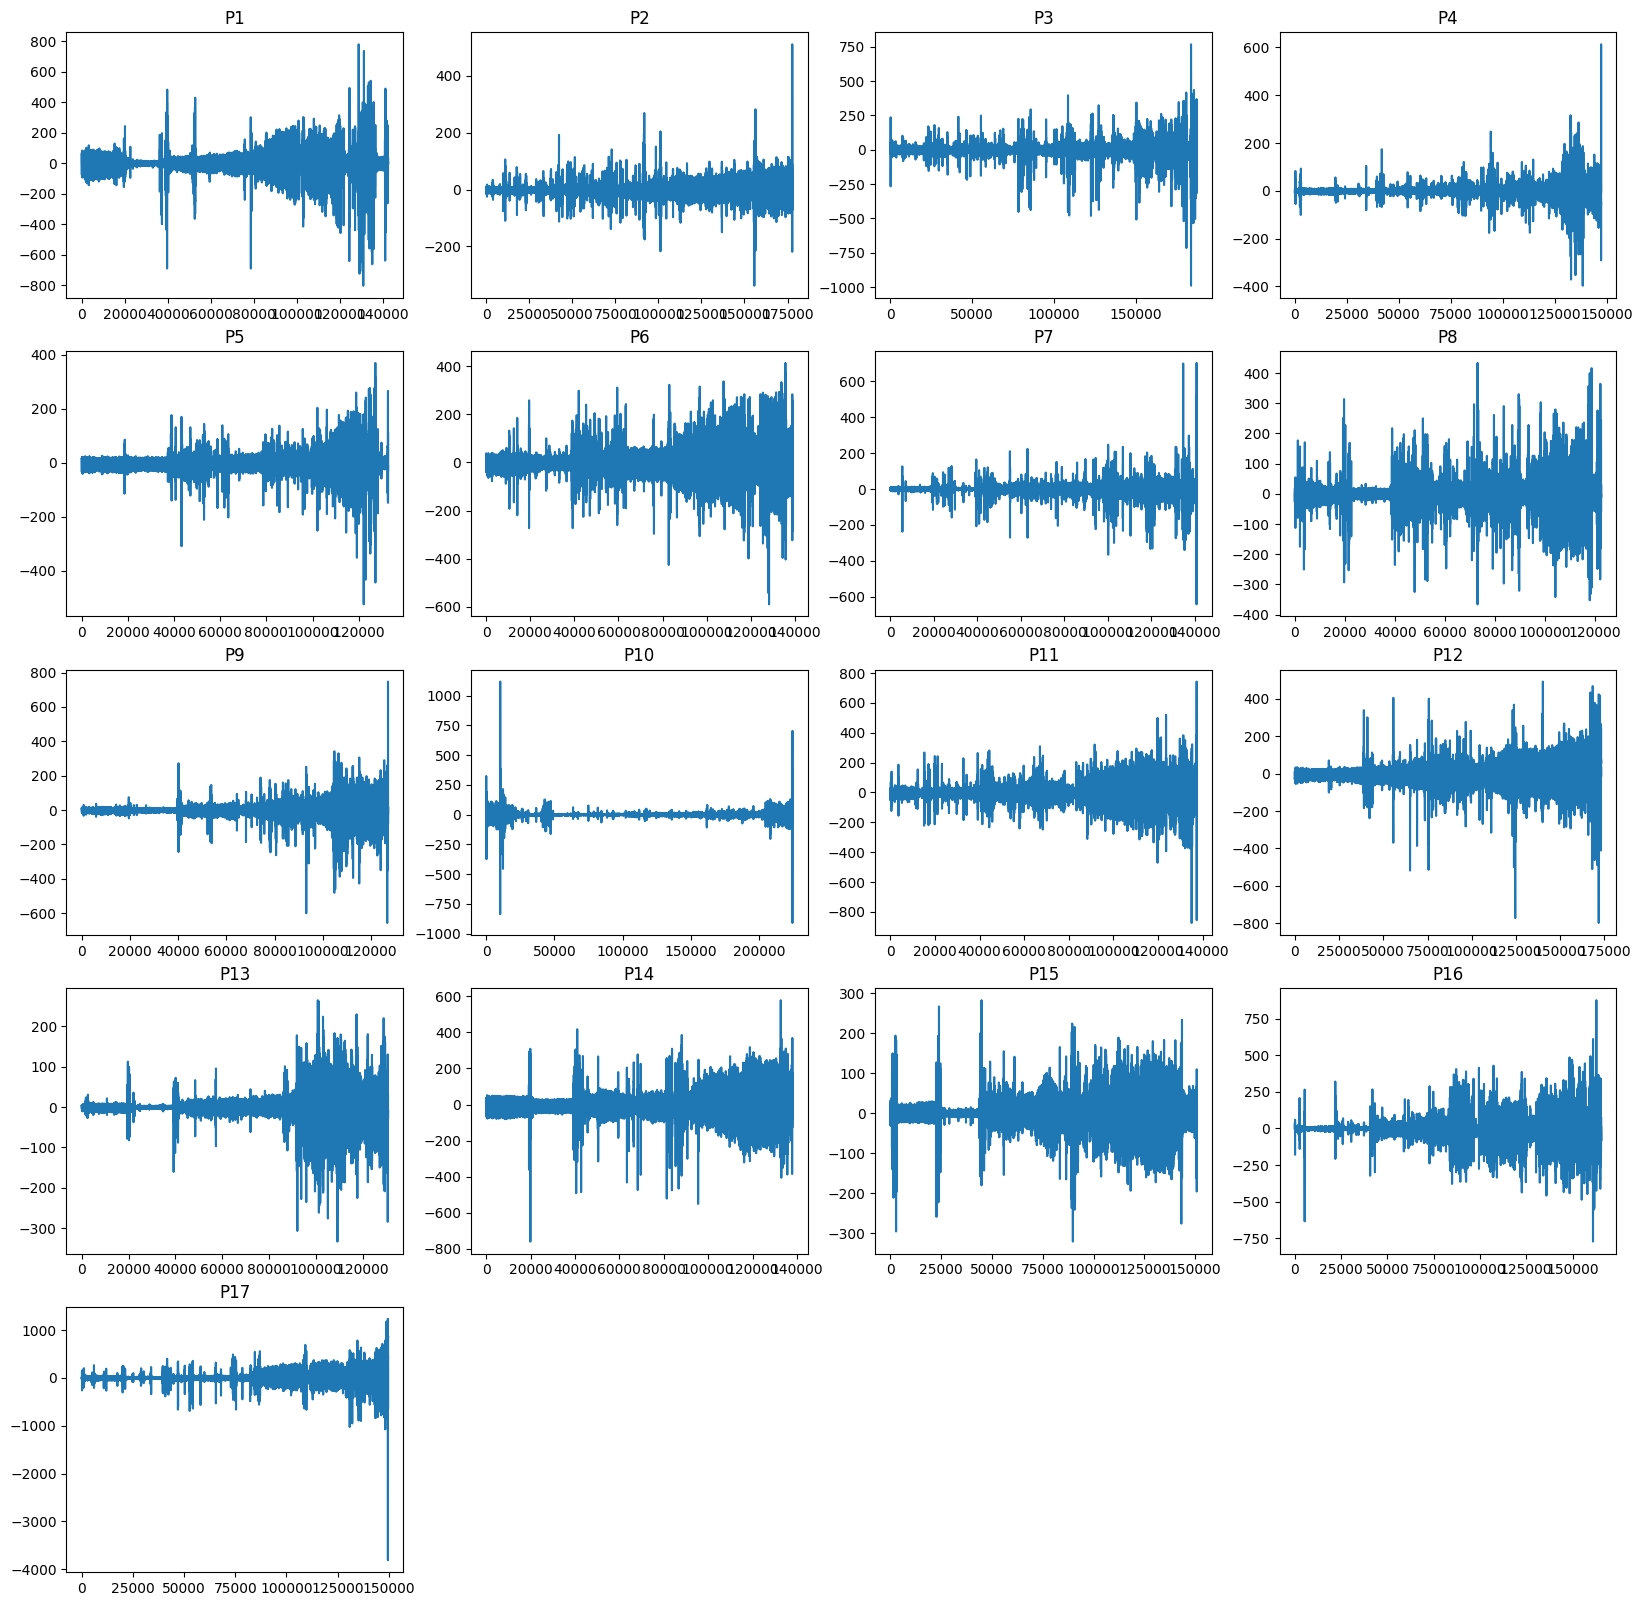

In [16]:
line_plots(ppg_e4_dfs)

#### Box Plot

In [17]:
def box_plots(dfs):
    fig = plt.figure(figsize=(20, 40))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(5, 4, i+1)
        ax.title.set_text(f"P{i+1}")
        plot_df = pd.DataFrame(data=df["ppg_raw"].values, columns=["ppg_raw"])
        sns.boxplot(data=plot_df, ax=fig.axes[i])

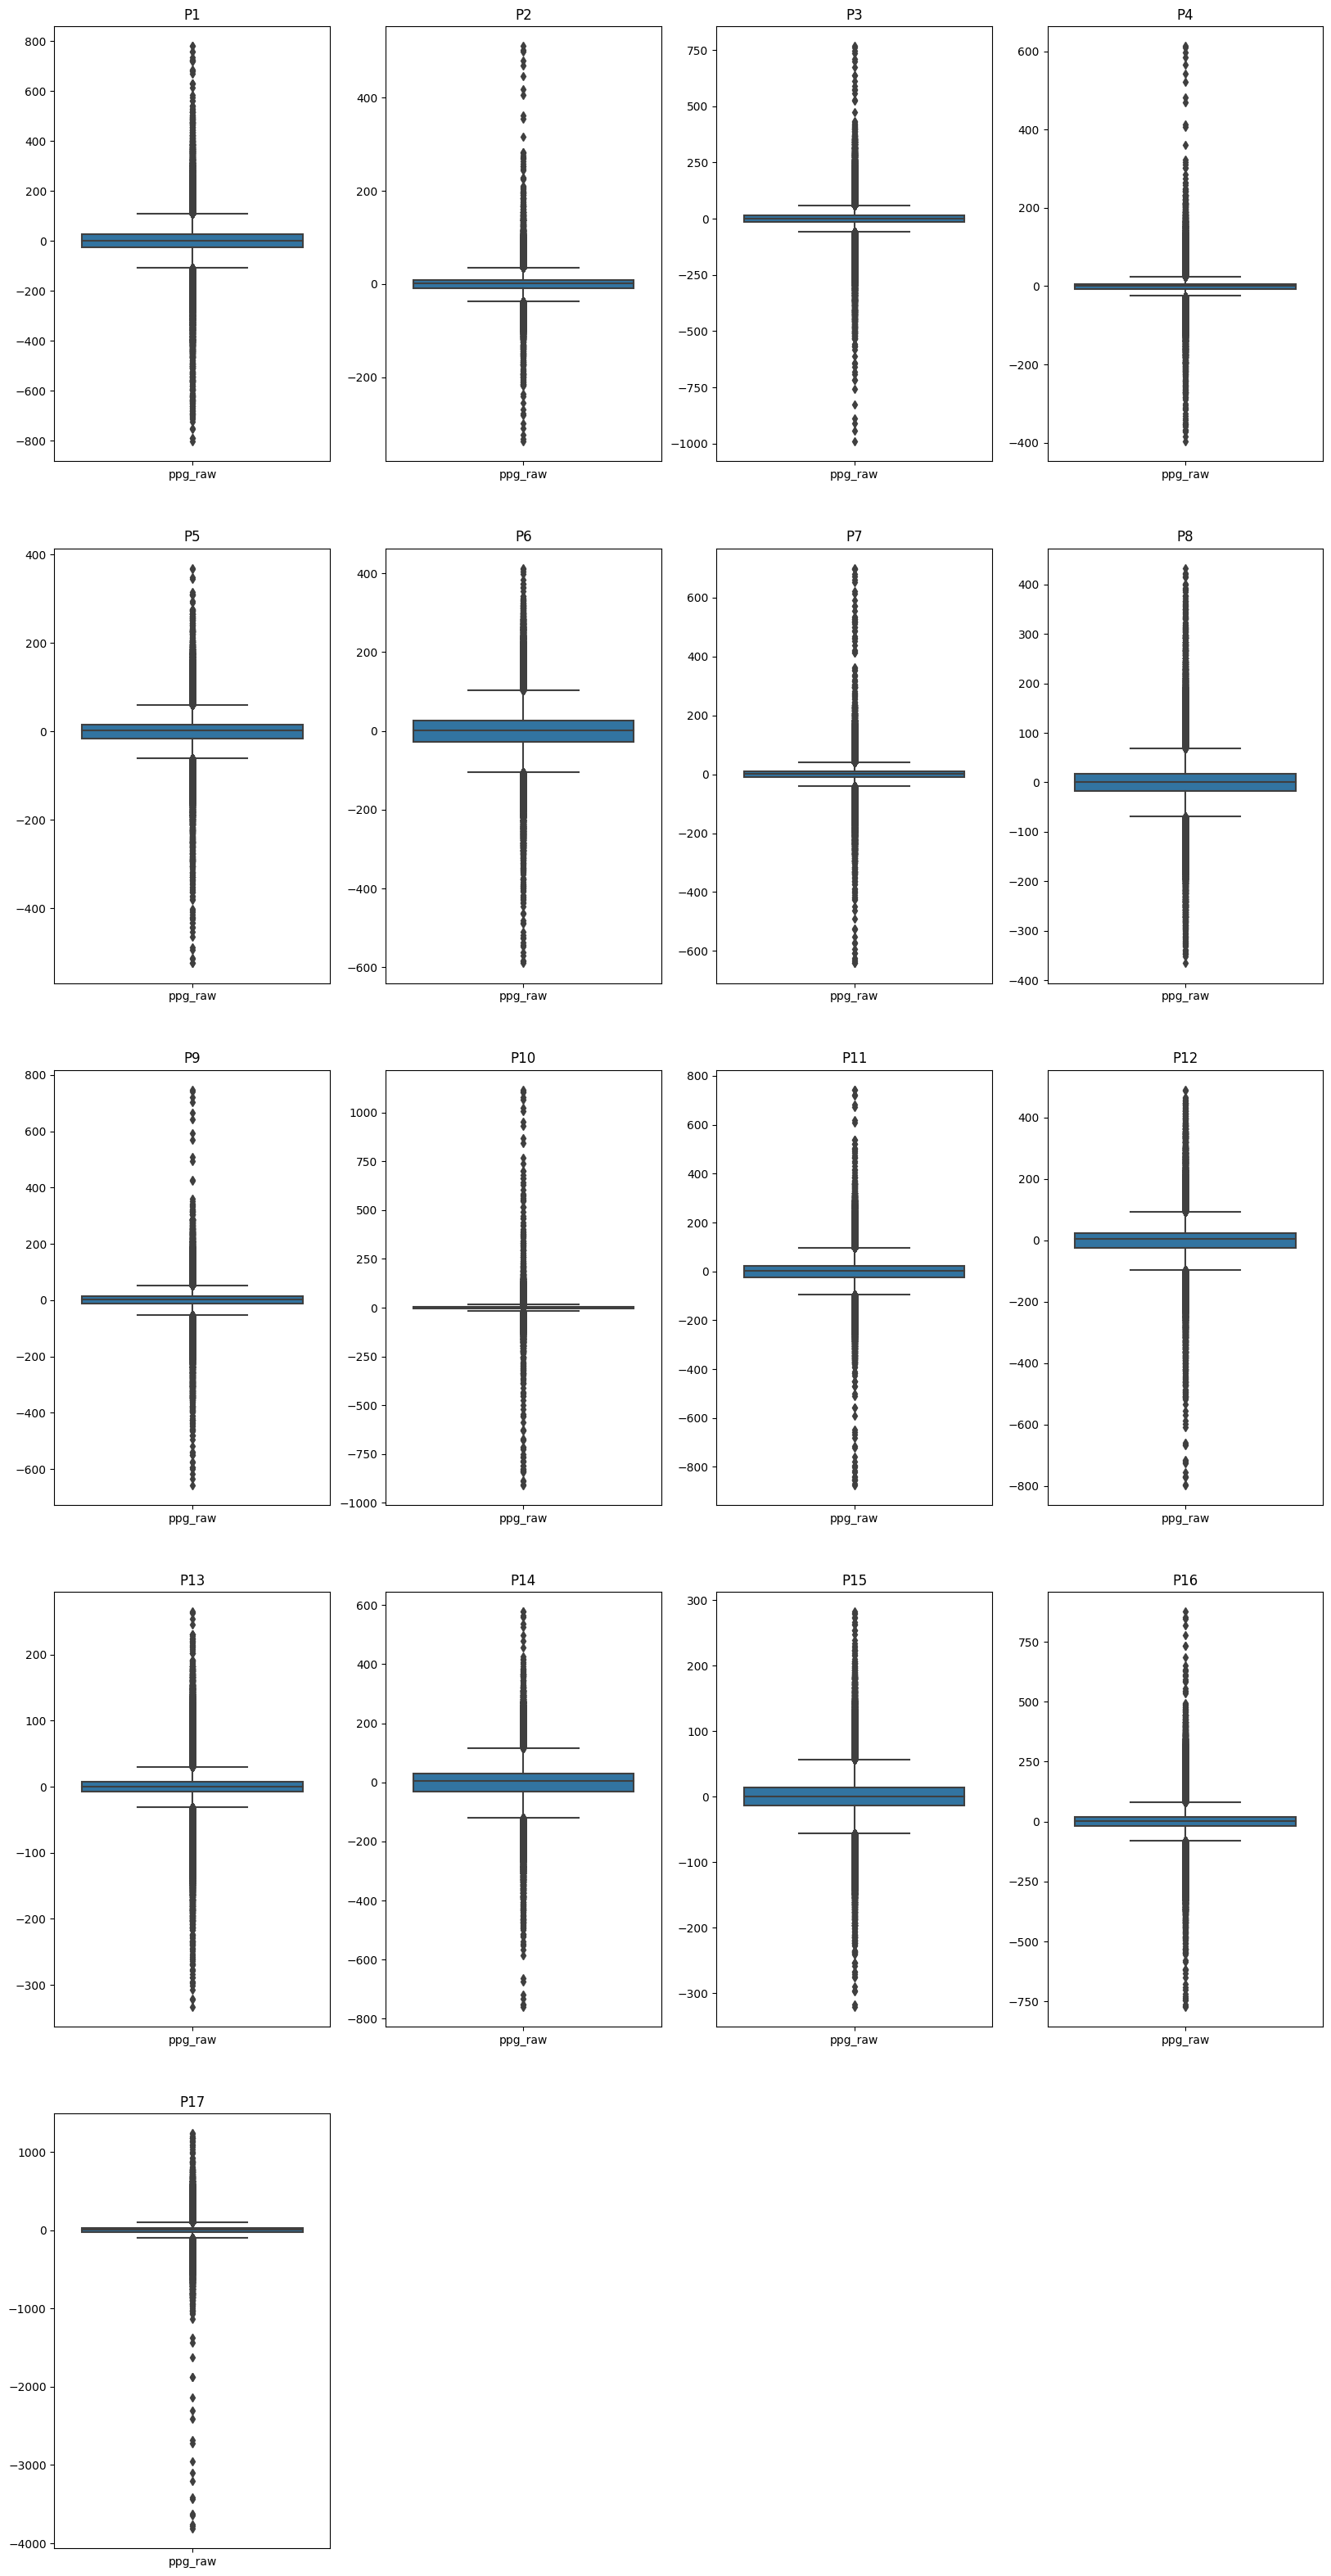

In [18]:
box_plots(ppg_e4_dfs)

#### Histogram Plots

In [19]:
def hist_plots(dfs):
    fig = plt.figure(figsize=(20, 20))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(5, 4, i+1)
        ax.title.set_text(f"P{i+1}")
        plot_df = pd.DataFrame(data=df["ppg_raw"].values, columns=["ppg_raw"])
        sns.histplot(data=plot_df, bins=20, ax=fig.axes[i])

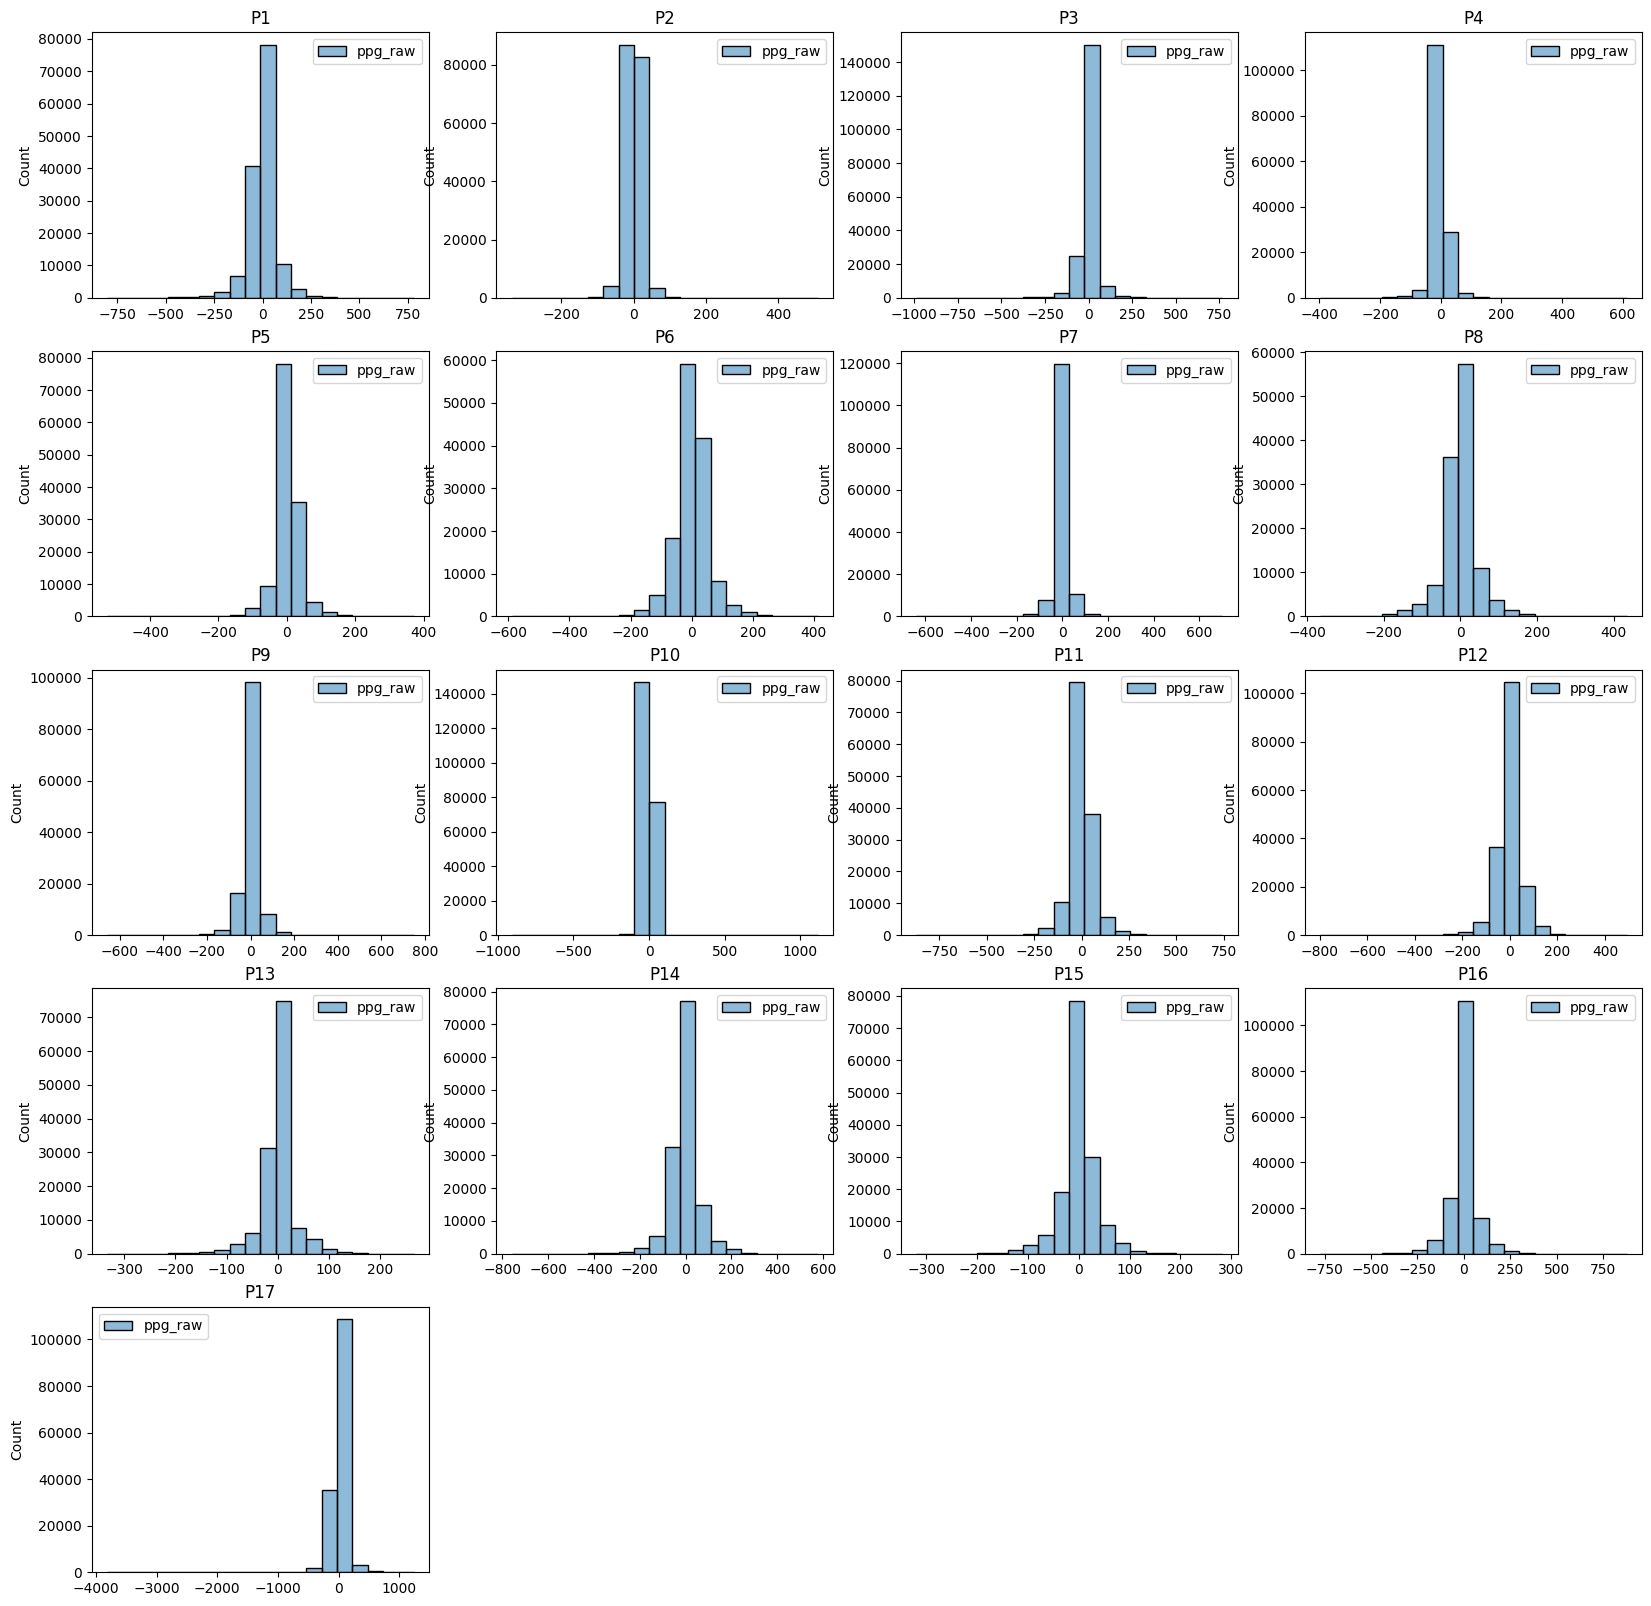

In [20]:
hist_plots(ppg_e4_dfs)

## Cleaning the Data

### E4 PPG Data

We will be using `HeartPy` library to clean and extract features from the PPG data.

> First, the data is cleaned using the Butterworth Bandpass Filter. The cutoff range is used as 0.7 Hz (42 bpm) and 3.5 Hz (210 bpm).

In [21]:
# Butterworth Bandpass Filter
def bt_filter(df, column, lowcut, highcut, order):
    return hp.filter_signal(
        data=df[column].values,
        cutoff=[lowcut, highcut],
        sample_rate=FREQUENCY,
        order=order,
        filtertype='bandpass'
    ) 

In [22]:
# cleaned ppg data of all the participants using Butterworth Bandpass Filter
cleaned_ppg_e4_arrs = [bt_filter(df, "ppg_raw", 0.7, 3.5, 3) for df in ppg_e4_dfs]

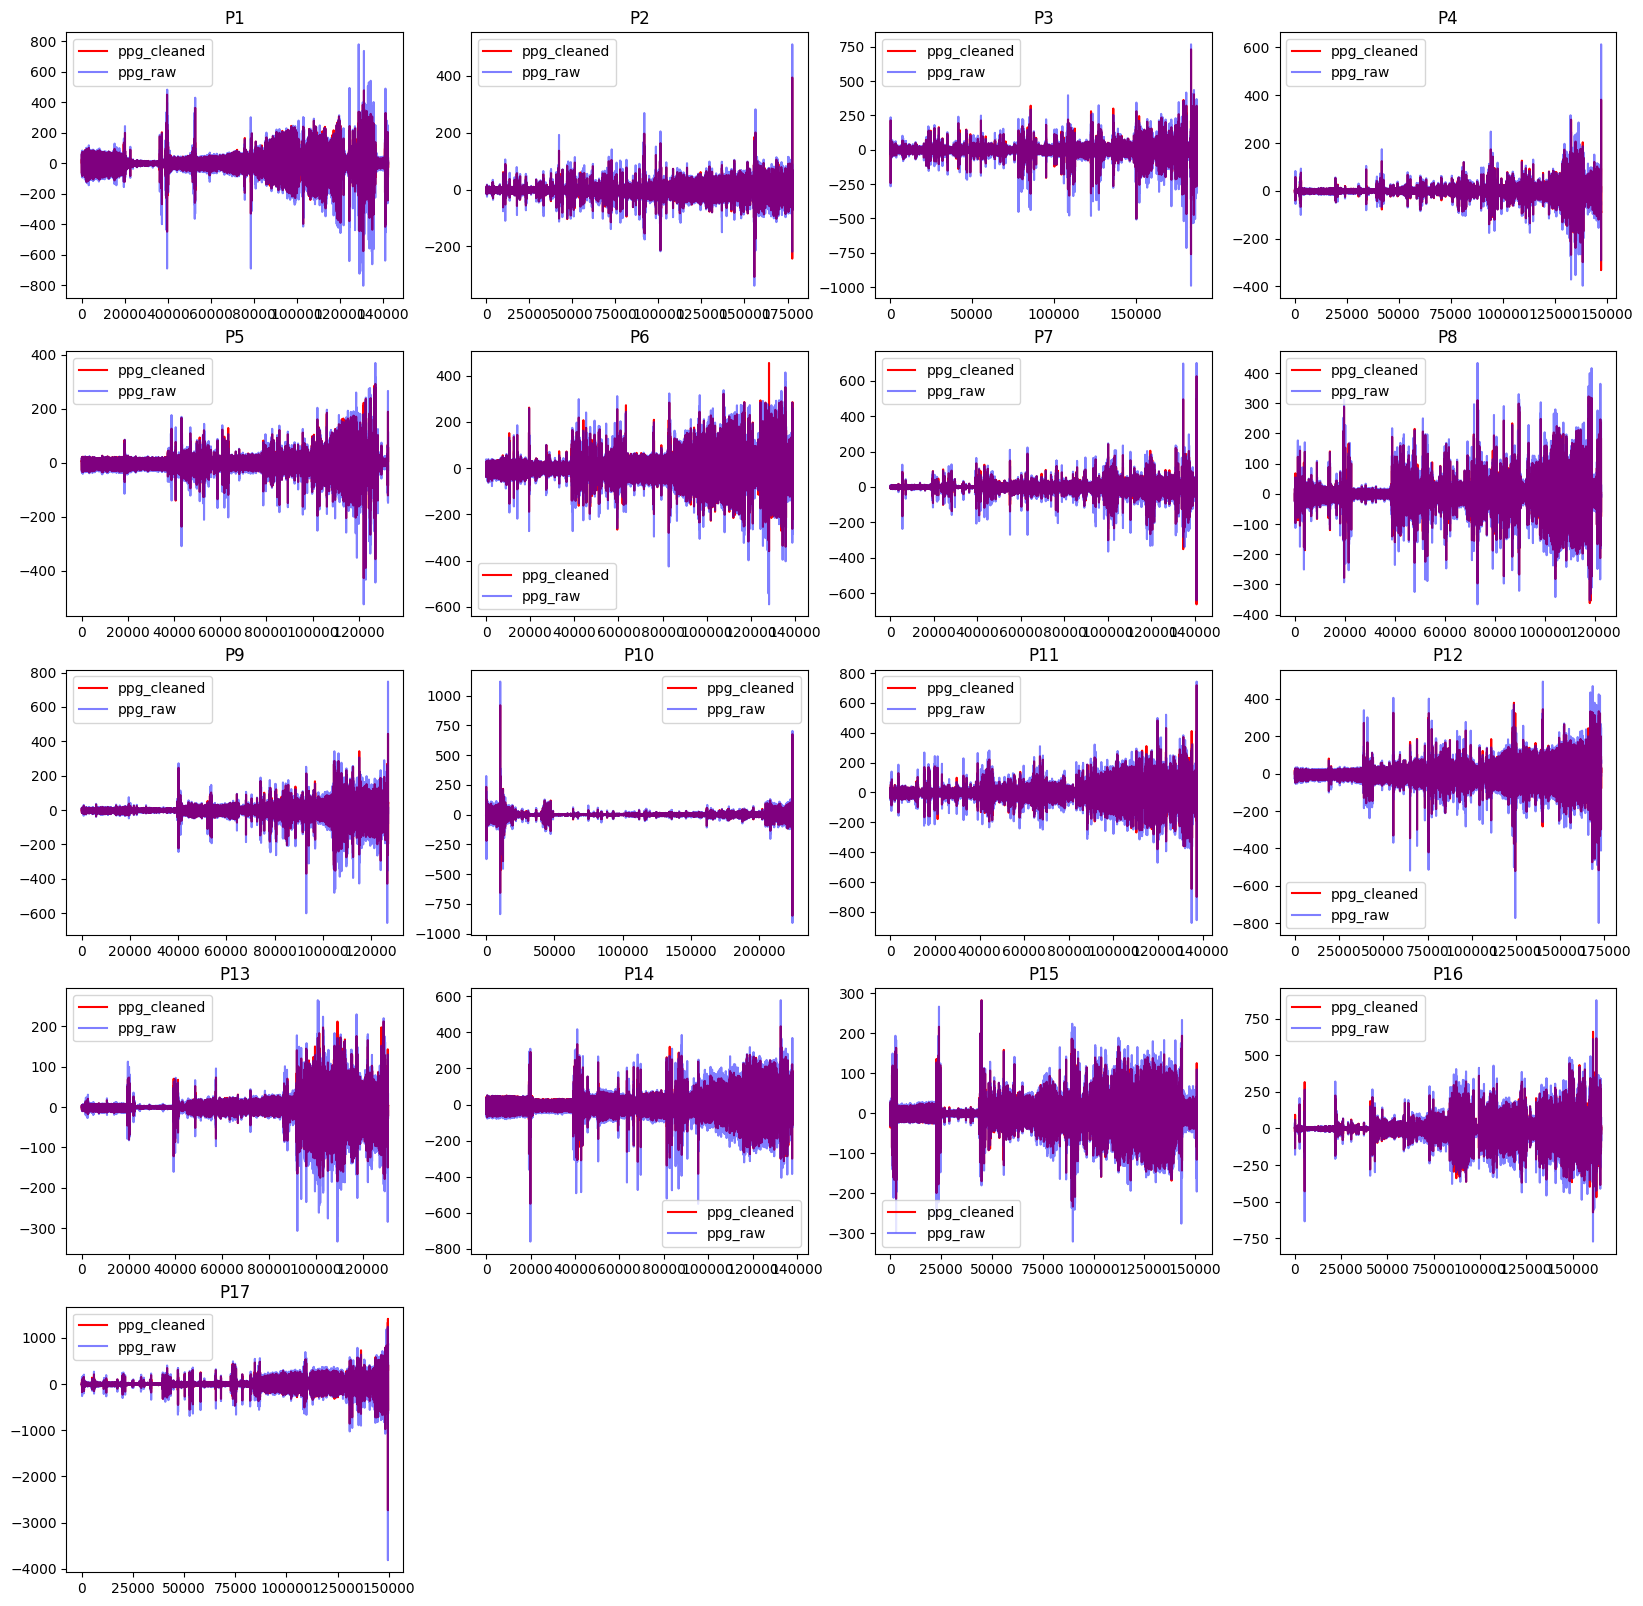

In [23]:
# plots with cleaned data
fig = plt.figure(figsize=(20, 20))

for i in range(len(cleaned_ppg_e4_arrs)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.title.set_text(f"P{i+1}")
    ax.plot(cleaned_ppg_e4_arrs[i], color="red", label="ppg_cleaned")
    ax.plot(ppg_e4_dfs[i]["ppg_raw"].values, alpha=0.5, color="blue", label="ppg_raw")
    ax.legend()

plt.show()

For E4 PPG data, a time window of `10s` is considered for PPG measurements.

In [24]:
# preprocess
def preprocess_e4(arr, window_size):
    out_cols = []
    out_arr = None

    try:
        for i in range(0, len(arr)-window_size+1):
            # process data
            working_data, measures = hp.process(arr[i:i+window_size], FREQUENCY)
            if i == 0:
                out_cols = list(measures.keys())
                out_arr = np.array([list(measures.values())])
            else:
                out_arr = np.append(out_arr, [list(measures.values())], axis=0)
    except:
        out_arr = np.append(out_arr, [[np.nan for _ in range(len(out_cols))]], axis=0)
    return pd.DataFrame(data=out_arr, columns=out_cols)

In [25]:
# new dataframe of inferred results
inferred_ppg_dfs = []
WINDOW_SIZE = 10 # 10 seconds

In [26]:
# inferred_ppg_dfs.append(preprocess_e4(cleaned_ppg_e4_arrs[0], int(WINDOW_SIZE*FREQUENCY)))

## Adding New Attributes to the Data

In this section we will adding a few new fields to the data to maintain consistency among our datasets.

Let's load the demographic data of each user.

In [27]:
demographic_df = pd.read_csv(os.path.join(DATASET_PATH, DATASET_VERSION, "Demographics.csv"))
demographic_df.drop(columns=["Comments"], inplace=True)

In [28]:
# lowering the case of the column names
demographic_df.columns = demographic_df.columns.str.lower()

In [29]:
# updating column names
demographic_df.columns = ["user_id"] + [f"user_{col}" for col in demographic_df.columns[1:]]

In [30]:
demographic_df.head()

,user_id,user_bmi,user_fat,user_muscle,user_water,user_bone,user_weight,user_height,user_gender,user_age
0,P01,24.7,33,14,49,4,70.6,166,F,29
1,P02,25.7,20,15,54,4,77.0,173,M,26
2,P03,20.6,23,16,57,5,61.0,172,F,26
3,P04,26.6,17,15,53,4,81.5,175,M,27
4,P05,24.8,31,14,48,4,66.0,163,F,33


#### Categorical Encoding

Gender is the only categorical variable available in the dataset. We encode it using an `Ordinal Encoder` by mapping values as follows.
- "M": 0
- "F": 1 

In [31]:
# encoder = ce.OrdinalEncoder(
#     cols=["user_gender"],
#     return_df=True,
#     mapping=[{
#         "col": "user_gender",
#         "mapping": {
#             "M": 0,
#             "F": 1
#         }
#     }]
# )
# encoder.fit_transform(demographic_df)

### Loading Data (Temporary)

In [32]:
inferred_ppg_dfs = [pd.read_csv(f"temp_csv/P{i:02}.csv") for i in range(17)]

In [33]:
inferred_ppg_dfs[0].head()

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,95.150442,630.580357,20.120264,14.423077,26.001572,0.384615,0.0,15.625,18.307147,22.162366,1274.637441,0.826047,0.226655
1,95.150442,630.580357,20.120264,14.423077,26.001572,0.384615,0.0,15.625,18.307147,22.162366,1274.637441,0.826047,0.226655
2,95.150442,630.580357,20.120264,14.423077,26.001572,0.384615,0.0,15.625,18.307147,22.162366,1274.637441,0.826047,0.226655
3,95.150442,630.580357,20.120264,14.423077,26.001572,0.384615,0.0,15.625,18.307147,22.162366,1274.637441,0.826047,0.226655
4,95.150442,630.580357,20.120264,14.423077,26.001572,0.384615,0.0,15.625,18.307147,22.162366,1274.637441,0.826047,0.226655


### Page Break

In this step we will be adding the following fields to the datasets.
- `user id`
- `timestamp`: later converted into `stating timestamp` and `ending timestamp`.
- `session type`

In [34]:
# add user id
for i, df in enumerate(inferred_ppg_dfs):
    df["user_id"] = i + 1
    new_cols = ["user_id"] + df.columns.tolist()[:-1]
    inferred_ppg_dfs[i] = df[new_cols]

In [35]:
# add timestamp
for i, df in enumerate(inferred_ppg_dfs):
    df["timestamp"] = float(starting_time_arr[i]) + df.index/FREQUENCY + WINDOW_SIZE/2 # timestamp starts from the middle of the window due to heart data preprocessing

In [36]:
# start times of each activity
start_stand = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Stand"]]
start_cycle1 = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Cycle1"]]
start_cycle2 = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Cycle2"]]
start_run1 = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Run1"]]
start_run2 = [startime_converter(datetime.datetime.strptime(starting_time, "%Y-%m-%d %H:%M:%S")) for starting_time in study_info_df["Start_Run2"]]

The 6 activity types of the WEEE dataset is encoded as follows.
- 0: Sit
- 1: Stand
- 2: Cycle (Speed 1)
- 3: Cycle (Speed 2)
- 4: Run (Speed 1)
- 5: Run (Speed 2)

In [37]:
# add session type
def add_session_type(df, start_stand, start_cycle1, start_cycle2, start_run1, start_run2):
    df["session_type"] = 0
    df.loc[df["timestamp"] >= start_stand, "session_type"] = 1
    df.loc[df["timestamp"] >= start_cycle1, "session_type"] = 2
    df.loc[df["timestamp"] >= start_cycle2, "session_type"] = 3
    df.loc[df["timestamp"] >= start_run1, "session_type"] = 4
    df.loc[df["timestamp"] >= start_run2, "session_type"] = 5
    return df

In [38]:
inferred_ppg_dfs = [add_session_type(df, start_stand[i], start_cycle1[i], start_cycle2[i], start_run1[i], start_run2[i]) for i, df in enumerate(inferred_ppg_dfs)]

## Saving the Data

In this step we will combine all user's data with some additional field and save them under 2, 4, 6, 8, 10, 12 (s) windows.

In [40]:
# timestamp to datetime converter
def timestamp_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp, datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

In [65]:
# add time windows
time_windows = [2, 4, 6, 8, 10, 12]
for window in time_windows:
    print(f"Window Size: {window} seconds")
    TIME_WINDOW = int(window * FREQUENCY) # size of the time window to consider
    output_df = pd.DataFrame()

    for j, df in enumerate(inferred_ppg_dfs):
        print(f"Processing User: {j+1:02}")

        # start and end timestamps
        df["start_timestamp"] = np.nan
        df["end_timestamp"] = np.nan

        # crop additional data per session type
        cropped_sessions = []
        df["window_number"] = 0 # window number field
        for i in range(6):
            session_length = len(df[df["session_type"] == i])
            temp_df = df[df["session_type"] == i].reset_index(drop=True).iloc[:(session_length//TIME_WINDOW)*TIME_WINDOW]
            temp_df["window_number"] = temp_df.index//TIME_WINDOW
            cropped_sessions.append(temp_df)
        df = pd.concat(cropped_sessions, ignore_index=True).reset_index(drop=True)

        # for each time window
        for i in range(0, len(df)//TIME_WINDOW):
            start_timestamp = df["timestamp"].iloc[i*TIME_WINDOW]
            end_timestamp = start_timestamp + window

            # average columns
            int_columns = ["user_id", "session_type", "window_number", "start_timestamp", "end_timestamp"]
            feature_columns = df.columns.tolist()
            feature_columns.remove("timestamp")

            # add tsfresh features
            window_df = df[feature_columns].iloc[i*TIME_WINDOW:(i+1)*TIME_WINDOW].reset_index(drop=True)
            modified_df = pd.DataFrame()
            for col in feature_columns:
                if col in int_columns:
                    modified_df[col] = [window_df[col][0]]
                else:
                    modified_df = pd.concat([modified_df, pd.DataFrame({
                        f"{col}_sum_values_e4_ppg": [fc.sum_values(window_df[col])],
                        f"{col}_median_e4_ppg": [fc.median(window_df[col])],
                        f"{col}_mean_e4_ppg": [fc.mean(window_df[col])],
                        f"{col}_length_e4_ppg": [fc.length(window_df[col])],
                        f"{col}_standard_deviation_e4_ppg": [fc.standard_deviation(window_df[col])],
                        f"{col}_variance_e4_ppg": [fc.variance(window_df[col])],
                        f"{col}_root_mean_square_e4_ppg": [fc.root_mean_square(window_df[col])],
                        f"{col}_maximum_e4_ppg": [fc.maximum(window_df[col])],
                        f"{col}_absolute_maximum_e4_ppg": [fc.absolute_maximum(window_df[col])],
                        f"{col}_minimum_e4_ppg": [fc.minimum(window_df[col])]
                    })], axis=1)
            
            # add start and end timestamps
            modified_df["start_timestamp"] = timestamp_to_datetime(start_timestamp)
            modified_df["end_timestamp"] = timestamp_to_datetime(end_timestamp)


            # add to output df
            output_df = pd.concat([output_df, modified_df], ignore_index=True)

    # save data
    if not os.path.exists(os.path.join(DATASET_PATH, DATASET_OUTPUT_VERSION, str(window), "E4")):
        os.makedirs(os.path.join(DATASET_PATH, DATASET_OUTPUT_VERSION, str(window), "E4"))

    output_df.to_csv(os.path.join(DATASET_PATH, DATASET_OUTPUT_VERSION, str(window), "E4", "PPG.csv"), index=False)
            
            

Processing User: 01 | Window Size: 2 seconds
Processing User: 02 | Window Size: 2 seconds


In [66]:
output_df.head()

,user_id,bpm_sum_values_e4_ppg,bpm_median_e4_ppg,bpm_mean_e4_ppg,bpm_length_e4_ppg,bpm_standard_deviation_e4_ppg,bpm_variance_e4_ppg,bpm_root_mean_square_e4_ppg,bpm_maximum_e4_ppg,bpm_absolute_maximum_e4_ppg,...,breathingrate_standard_deviation_e4_ppg,breathingrate_variance_e4_ppg,breathingrate_root_mean_square_e4_ppg,breathingrate_maximum_e4_ppg,breathingrate_absolute_maximum_e4_ppg,breathingrate_minimum_e4_ppg,session_type,start_timestamp,end_timestamp,window_number
0,1,12083.431016,94.271686,94.401805,128,0.572234,0.327451,94.403539,96.000000,96.000000,...,0.115874,0.013427,0.262800,0.338181,0.338181,0.000000,0,2021-12-03 16:58:55,2021-12-03 16:58:57,0
1,1,11951.621355,93.354943,93.372042,128,0.247020,0.061019,93.372369,94.271686,94.271686,...,0.042316,0.001791,0.251079,0.314432,0.314432,0.207254,0,2021-12-03 16:58:57,2021-12-03 16:58:59,1
2,1,11967.666273,93.430718,93.497393,128,0.372895,0.139051,93.498136,94.581281,94.581281,...,0.008903,0.000079,0.215750,0.238521,0.238521,0.206590,0,2021-12-03 16:58:59,2021-12-03 16:59:01,2
3,1,12000.338802,93.658537,93.752647,128,0.241798,0.058466,93.752959,94.736842,94.736842,...,0.046591,0.002171,0.299820,0.335308,0.335308,0.207254,0,2021-12-03 16:59:01,2021-12-03 16:59:03,3
4,1,12042.435220,94.117647,94.081525,128,0.451920,0.204231,94.082611,95.522388,95.522388,...,0.102885,0.010585,0.264803,0.359799,0.359799,0.104308,0,2021-12-03 16:59:03,2021-12-03 16:59:05,4


In [67]:
output_df.columns.tolist()

['user_id',
 'bpm_sum_values_e4_ppg',
 'bpm_median_e4_ppg',
 'bpm_mean_e4_ppg',
 'bpm_length_e4_ppg',
 'bpm_standard_deviation_e4_ppg',
 'bpm_variance_e4_ppg',
 'bpm_root_mean_square_e4_ppg',
 'bpm_maximum_e4_ppg',
 'bpm_absolute_maximum_e4_ppg',
 'bpm_minimum_e4_ppg',
 'ibi_sum_values_e4_ppg',
 'ibi_median_e4_ppg',
 'ibi_mean_e4_ppg',
 'ibi_length_e4_ppg',
 'ibi_standard_deviation_e4_ppg',
 'ibi_variance_e4_ppg',
 'ibi_root_mean_square_e4_ppg',
 'ibi_maximum_e4_ppg',
 'ibi_absolute_maximum_e4_ppg',
 'ibi_minimum_e4_ppg',
 'sdnn_sum_values_e4_ppg',
 'sdnn_median_e4_ppg',
 'sdnn_mean_e4_ppg',
 'sdnn_length_e4_ppg',
 'sdnn_standard_deviation_e4_ppg',
 'sdnn_variance_e4_ppg',
 'sdnn_root_mean_square_e4_ppg',
 'sdnn_maximum_e4_ppg',
 'sdnn_absolute_maximum_e4_ppg',
 'sdnn_minimum_e4_ppg',
 'sdsd_sum_values_e4_ppg',
 'sdsd_median_e4_ppg',
 'sdsd_mean_e4_ppg',
 'sdsd_length_e4_ppg',
 'sdsd_standard_deviation_e4_ppg',
 'sdsd_variance_e4_ppg',
 'sdsd_root_mean_square_e4_ppg',
 'sdsd_maximum_e4